In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from datetime import datetime
from scipy import stats

In [2]:
con = sqlite3.connect(r"C:\Users\Mauro\OneDrive - АНО ВО Университет Иннополис\Документы\Innopolis\Empirical Methods\DataPrimaryProject\user10.sqlite")

In [3]:
signals_data = pd.read_sql_query("""SELECT * FROM Signals;""", con)
images_data = pd.read_sql_query("""SELECT * FROM Images;""", con)

In [4]:
filter_data = images_data.loc[(images_data["state"] == "Present") | (images_data["state"] == "Absent")]

filter_data["dateTime"] = pd.to_datetime(filter_data["dateTime"])

sig_ti = signals_data.dateTime

<ipython-input-4-9e2eea3a92a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["dateTime"] = pd.to_datetime(filter_data["dateTime"])


In [5]:
newfd = filter_data.filter(['id','dateTime','state'], axis=1)

newfd = newfd.reset_index(drop=True)

In [6]:
newfd

,id,dateTime,state
0,3,2021-03-30 13:00:50.296966,Absent
1,5,2021-03-30 13:00:51.091863,Present
2,7,2021-03-30 13:01:17.452682,Present
3,9,2021-03-30 13:01:43.328120,Present
4,11,2021-03-30 13:01:58.903678,Present
...,...,...,...
887,1755,2021-05-14 17:36:30.014077,Present
888,1757,2021-05-14 17:36:40.606190,Present
889,1759,2021-05-14 17:36:42.957721,Present
890,1761,2021-05-14 17:38:10.272145,Present


In [7]:
pstates = list()
astates = list()

states = newfd.groupby([(newfd.state != newfd.state.shift()).cumsum()]) 

for i, g in states:
    if (len(g.dateTime.tolist()) > 1)  &  (g.state.all() == 'Present'):
        pstates.append((newfd.dateTime.iloc[g.index[0]],newfd.dateTime.iloc[g.index[0]+len(g)-1]))
    elif (g.state.all() == 'Absent') & (i > 1) & (i < len(states)-1):
        astates.append((newfd.dateTime.iloc[g.index[0]-1],newfd.dateTime.iloc[g.index[0]+len(g)]))

In [8]:
pre_sig = list()                                                             # Duration of the signals of the Present intervals

for m in range (0,len(pstates)):
    pre_intervals = list()
    for n in sig_ti:
        if (str(pstates[m][0]) <= n) &  (n <= str(pstates[m][1])):
           pre_intervals.append(n) 
    if len(pre_intervals) > 1:
       inter = pd.Series(pre_intervals, dtype = 'object')
       inter = pd.to_datetime(inter)
    pre_sig.append(inter.iloc[-1] - inter.iloc[0])

In [9]:
abs_sig = list()                                                             # Duration of the signals of the Present intervals

for m in range (0,len(astates)):
    abs_intervals = list()
    for n in sig_ti:
        if (str(astates[m][0]) <= n) &  (n <= str(astates[m][1])):
           abs_intervals.append(n) 
    if len(abs_intervals) > 1:
       inter = pd.Series(abs_intervals, dtype = 'object')
       inter = pd.to_datetime(inter)
    abs_sig.append(inter.iloc[-1] - inter.iloc[0])

In [10]:
pre_sig 

[Timedelta('0 days 00:00:57.848237'),
 Timedelta('0 days 00:02:34.158882'),
 Timedelta('0 days 00:02:34.158882'),
 Timedelta('0 days 00:06:25.531796'),
 Timedelta('0 days 00:00:14.823752'),
 Timedelta('0 days 00:01:48.599324'),
 Timedelta('0 days 00:01:48.599324'),
 Timedelta('0 days 00:05:44.914747'),
 Timedelta('0 days 00:14:11.717796'),
 Timedelta('0 days 00:00:03.351366'),
 Timedelta('0 days 00:00:40.367965'),
 Timedelta('0 days 00:00:20.399555'),
 Timedelta('0 days 00:00:28.040437'),
 Timedelta('0 days 00:00:28.040437'),
 Timedelta('0 days 00:00:28.040437'),
 Timedelta('0 days 00:19:55.471130'),
 Timedelta('0 days 00:19:55.471130'),
 Timedelta('0 days 00:13:35.457764'),
 Timedelta('5 days 19:03:27.990920'),
 Timedelta('0 days 00:01:28.199564'),
 Timedelta('0 days 00:01:28.199564'),
 Timedelta('0 days 00:03:01.839084'),
 Timedelta('0 days 00:33:11.877833'),
 Timedelta('0 days 00:33:11.877833'),
 Timedelta('0 days 00:33:11.877833'),
 Timedelta('0 days 00:45:20.939677'),
 Timedelta('

In [11]:
abs_sig

[Timedelta('0 days 00:20:10.921536'),
 Timedelta('0 days 00:20:10.921536'),
 Timedelta('0 days 00:20:10.921536'),
 Timedelta('0 days 00:20:10.921536'),
 Timedelta('0 days 00:02:07.338004'),
 Timedelta('0 days 00:02:07.338004'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:53.431969'),
 Timedelta('0 days 00:00:03.063437'),
 Timedelta('0 days 00:00:03.063437'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:00:38.847536'),
 Timedelta('0 days 00:01:23.879914'),
 Timedelta('0 days 00:01:23.879914'),
 Timedelta('0 days 00:01:23.879914'),
 Timedelta('0 days 00:01:23.879914'),
 Timedelta('0 days 00:00:00.192142'),
 Timedelta('0 days 00:00:00.509596'),
 Timedelta('

In [12]:
a = pre_sig
b = abs_sig

In [13]:
a = [i.total_seconds()/60 for i in pre_sig ]                          # Time in seconds
b = [i.total_seconds()/60 for i in abs_sig ]                          # Time in seconds

alpha = 0.05

In [14]:
k2, p = stats.normaltest(a)

print("p = {:g}".format(p))
if p < alpha:                                       # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 5.6792e-21
The null hypothesis can be rejected


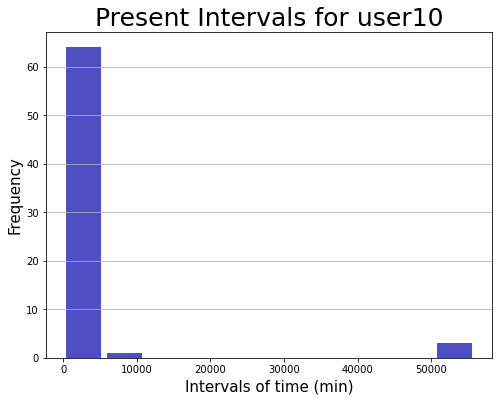

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(8,6))
plt.hist(x=a, bins=10, color='#0504aa',alpha=0.7, rwidth=0.85)

plt.xlabel('Intervals of time (min)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Present Intervals for user10', fontsize=25)
plt.grid(axis='y')
plt.show()
plt.savefig('user10a.png')

C:\Users\Mauro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


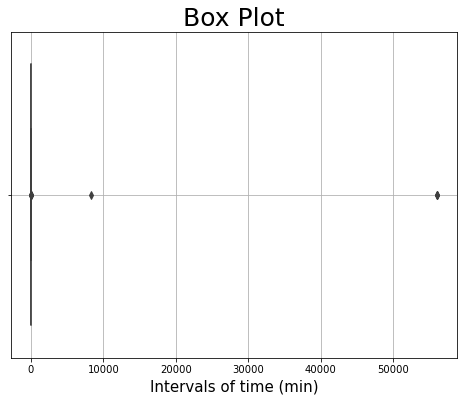

In [16]:
plt.figure(figsize=(8,6))
plt.title('Box Plot', fontsize=25)
sns.boxplot(a)
plt.xlabel('Intervals of time (min)', fontsize=15)
plt.grid()

In [17]:
k2, p = stats.normaltest(b)

print("p = {:g}".format(p))
if p < alpha:                                       # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 3.25466e-25
The null hypothesis can be rejected


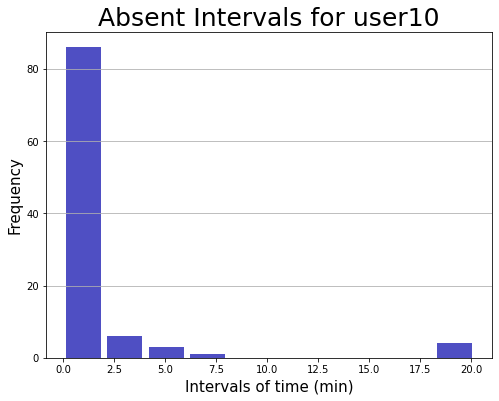

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(8,6))
plt.hist(x=b, bins=10, color='#0504aa',alpha=0.7, rwidth=0.85)

plt.xlabel('Intervals of time (min)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Absent Intervals for user10', fontsize=25)
plt.grid(axis='y')
plt.show()
plt.savefig('user10b.png')

C:\Users\Mauro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


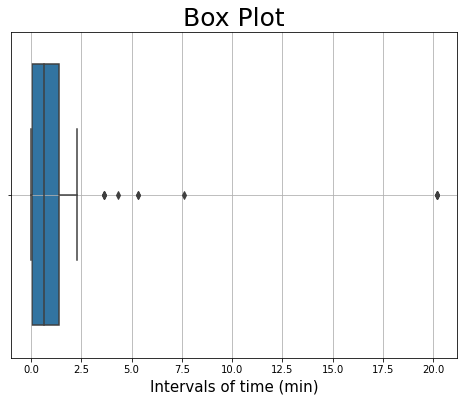

In [19]:
plt.figure(figsize=(8,6))
plt.title('Box Plot', fontsize=25)
sns.boxplot(b)
plt.xlabel('Intervals of time (min)', fontsize=15)
plt.grid()